In [ ]:
import os 
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.preprocessing import image
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from skimage.io import imread, imsave
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.image as img
import pathlib

In [3]:
#Import data dari gdrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
file_dir = '/content/drive/MyDrive/DATA 5'
train_dir = os.path.join(file_dir, 'train')
valid_dir = os.path.join(file_dir, 'testing')
test_dir = os.path.join(file_dir, 'testing')


In [6]:
#Image data generator untuk dataset 
train_generator = ImageDataGenerator(rescale=1/255,
                                     shear_range=0.3,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     rotation_range=60)

train_data = train_generator.flow_from_directory("/content/drive/MyDrive/DATA 5/train",
                                                 target_size=(224,224),
                                                 batch_size=22,
                                                 class_mode="categorical")

#Image data generator untuk validasi
validation_generator = ImageDataGenerator(rescale=1/255,
                                          shear_range=0.3,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          rotation_range=60)

validation_data = validation_generator.flow_from_directory("/content/drive/MyDrive/DATA 5/testing",
                                                 target_size=(224,224),
                                                 batch_size=19,
                                                 class_mode="categorical")

Found 440 images belonging to 5 classes.
Found 185 images belonging to 5 classes.


In [7]:
base_model = tf.keras.applications.InceptionResNetV2(input_shape = (224,224,3),
                                               include_top = False,
                                               weights ='imagenet')

219070464/219055592 [==============================] - 2s 0us/step


In [8]:
base_model.trainable= False

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy')>0.90):
      print("\n sudah mencapai 90% accuracy so cancelling training!")
      self.model.stop_training = True

In [10]:
#Setting Arsitektur CNN
model_image= tf.keras.models.Sequential([ 
base_model,
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(5, activation='softmax')
])

In [11]:
from tensorflow.keras.optimizers import SGD
model_image.compile(loss='categorical_crossentropy',
                    optimizer= SGD(learning_rate=0.001, momentum=0.9),
                    metrics=['accuracy'])

In [16]:
#Training Model
callbacks = myCallback()
history = model_image.fit(train_data,
                          steps_per_epoch= 20,
                          epochs= 150,
                          validation_data=validation_data,
                          validation_steps = 10,
                          verbose= 2,
                          callbacks= callbacks)

Epoch 1/150
20/20 - 13s - loss: 0.3305 - accuracy: 0.8705 - val_loss: 1.0299 - val_accuracy: 0.6865 - 13s/epoch - 652ms/step
Epoch 2/150
20/20 - 13s - loss: 0.3212 - accuracy: 0.8705 - val_loss: 1.0455 - val_accuracy: 0.7027 - 13s/epoch - 628ms/step
Epoch 3/150
20/20 - 12s - loss: 0.3387 - accuracy: 0.8727 - val_loss: 1.0625 - val_accuracy: 0.7081 - 12s/epoch - 624ms/step
Epoch 4/150
20/20 - 13s - loss: 0.3453 - accuracy: 0.8705 - val_loss: 1.0304 - val_accuracy: 0.6865 - 13s/epoch - 632ms/step
Epoch 5/150
20/20 - 13s - loss: 0.3578 - accuracy: 0.8705 - val_loss: 0.9560 - val_accuracy: 0.6703 - 13s/epoch - 634ms/step
Epoch 6/150
20/20 - 14s - loss: 0.3273 - accuracy: 0.8795 - val_loss: 1.0277 - val_accuracy: 0.6486 - 14s/epoch - 706ms/step
Epoch 7/150
20/20 - 13s - loss: 0.3472 - accuracy: 0.8659 - val_loss: 1.0202 - val_accuracy: 0.6973 - 13s/epoch - 638ms/step
Epoch 8/150
20/20 - 13s - loss: 0.3464 - accuracy: 0.8773 - val_loss: 0.9963 - val_accuracy: 0.7189 - 13s/epoch - 632ms/step


In [ ]:
#Plot Training

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Model', 'Validation Model'], loc='upper right')
plt.title('Nilai validasi loss pada tiap epoch')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Model', 'Validation Model'], loc='upper right')
plt.title('Nilai akurasi pada tiap epoch')
plt.show()

In [28]:
#Save Model
export_dir = 'saved_model/fix_ml'
tf.saved_model.save(model_image, export_dir)

INFO:tensorflow:Assets written to: saved_model/fix_ml/assets


INFO:tensorflow:Assets written to: saved_model/fix_ml/assets


In [29]:
model_image.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6

In [30]:
labels = sorted(os.listdir("/content/drive/MyDrive/DATA 5/train"))
print(labels)

['Acne', 'Actinic Keratosis', 'Basal Cell Carcinoma', 'Eczemaa', 'Rosacea']


Saving eczema.8.jpg to eczema.8.jpg
eczema.8.jpg
The image is classified as: Eczemaa


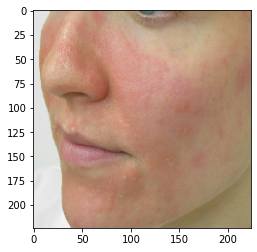

In [38]:
#Testing with upload foto
from keras.preprocessing import image
from google.colab import files

uploade = files.upload()

for ft in uploade.keys():

  pathtest = ft
  img = image.load_img(pathtest, target_size= (224, 224))
  imagplot = plt.imshow(img)
  xtest = image.img_to_array(img)
  xtest = np.expand_dims(xtest, axis=0)

  file_image = np.vstack([xtest])
  prediction_class = model_image.predict(file_image, batch_size=10)
  print(ft)

  output = prediction_class[0].argmax()
  print("The image is classified as:",labels[output])

  break

The image is classified as [0. 0. 0. 1. 0.]
Prediction for the image below: Eczemaa


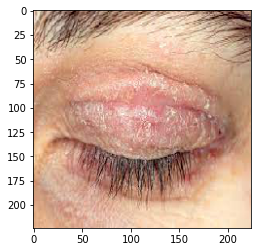

In [40]:
#Testing without upload foto
from keras.preprocessing import image

path = '/content/drive/MyDrive/DATA 5/testing/Eczemaa/eczema.25.jpg'
img = image.load_img(path, target_size=(224,224,3))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
plt.imshow(img)
img = np.expand_dims(img, axis = 0)
predictions = model_image.predict(img)
print("The image is classified as", predictions[0])
predicted_class = labels[np.argmax(predictions[0])]
print("Prediction for the image below:", predicted_class)

In [41]:
#Convert
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
with open('model_image.tflite', 'wb') as f:
  f.write(tflite_model)
